In [29]:
import psycopg2
import csv
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform, pdist
import pandas as pd
from psycopg2.extras import RealDictCursor
from scipy.stats import spearmanr
from sklearn.feature_selection import mutual_info_regression
import dcor

In [3]:
conn = psycopg2.connect(
    host="localhost",
    port=5432,
    dbname="test",
    user="siyuanzhao",
    cursor_factory=RealDictCursor
)
chromosome_name = 'chr1'
cell_line = 'K'
sequences = {"start": 770000, "end": 2705000}

In [ ]:
hic_file = "hic_data.csv"
position_file = "position.csv"
distance_file = "distance.csv"

cur = conn.cursor()
with open(hic_file, mode='r', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    for row in reader:
        hid = row["hid"]
        chrid = row["chrid"]
        ibp = row["ibp"]
        jbp = row["jbp"]
        fq = row["fq"]
        fdr = row["fdr"]
        rawc = row["rawc"]
        cell_line = row["cell_line"]
        
        insert_query = """
            INSERT INTO non_random_hic (hid, chrid, ibp, jbp, fq, fdr, rawc, cell_line)
            VALUES (%s, %s, %s, %s, %s, %s, %s, %s)
        """

        cur.execute(insert_query, (hid, chrid, ibp, jbp, fq, fdr, rawc, cell_line))

conn.commit()

# with open(position_file, mode='r', encoding='utf-8') as f:
#     reader = csv.DictReader(f)
#     for row in reader:
#         pid = row["pid"]
#         cell_line = row["cell_line"]
#         chrid = row["chrid"]
#         sampleid = row["sampleid"]
#         start_value = row["start_value"]
#         end_value = row["end_value"]
#         x = row["x"]
#         y = row["y"]
#         z = row["z"]
#         insert_time = row["insert_time"]
        
#         insert_query = """
#             INSERT INTO position (pid, cell_line, chrid, sampleid, start_value, end_value, x, y, z, insert_time)
#             VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
#         """

#         cur.execute(insert_query, (pid, cell_line, chrid, sampleid, start_value, end_value, x, y, z, insert_time))

# conn.commit()

# with open(distance_file, mode='r', encoding='utf-8') as f:
#     reader = csv.DictReader(f)
#     for row in reader:
#         did = row["did"]
#         cell_line = row["cell_line"]
#         chrid = row["chrid"]
#         sampleid = row["sampleid"]
#         start_value = row["start_value"]
#         end_value = row["end_value"]
#         n_beads = row["n_beads"]
#         distance_vector = row["distance_vector"]
#         insert_time = row["insert_time"]
        
#         insert_query = """
#             INSERT INTO distance (did, cell_line, chrid, sampleid, start_value, end_value, n_beads, distance_vector, insert_time)
#             VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s)
#         """

#         cur.execute(insert_query, (did, cell_line, chrid, sampleid, start_value, end_value, n_beads, distance_vector, insert_time))

# conn.commit()
cur.close()
conn.close()

In [4]:
def get_position_data(conn, chromosome_name, cell_line, sequences):
    cur = conn.cursor()
    cur.execute(
        """
        SELECT *
        FROM position
        WHERE chrid = %s
        AND cell_line = %s
        AND start_value = %s
        AND end_value = %s
        ORDER BY sampleid, pid
    """,
        (chromosome_name, cell_line, sequences["start"], sequences["end"]),
    )
    data = cur.fetchall()
    cur.close()
    return data

def get_distance_data(conn, chromosome_name, cell_line, sequences):
    cur = conn.cursor()
    cur.execute(
        """
        SELECT sampleid, distance_vector, n_beads
        FROM distance
        WHERE cell_line = %s
        AND chrid = %s
        AND start_value = %s
        AND end_value = %s
        ORDER BY sampleid
    """,
        (cell_line, chromosome_name, sequences["start"], sequences["end"]),
    )
    rows = cur.fetchall()
    cur.close()

    distance_data = []
    for row in rows:
        sample_data = {
            "sampleid": row["sampleid"],
            "distance_vector": row["distance_vector"],
            "n_beads": row["n_beads"]
        }
        distance_data.append(sample_data)
    
    return distance_data

def get_avg_distance_data(conn, chromosome_name, cell_line, sequences):
    cur = conn.cursor()
    cur.execute(
        """
        SELECT distance_vector
        FROM distance
        WHERE cell_line = %s
        AND chrid = %s
        AND start_value = %s
        AND end_value = %s
    """,
        (cell_line, chromosome_name, sequences["start"], sequences["end"]),
    )

    rows = cur.fetchall()
    cur.close()
    first_vector = np.array(rows[0]["distance_vector"], dtype=float)
    sum_vector = first_vector.copy()
    
    for row in rows:
        vector = np.array(row["distance_vector"], dtype=float)
        sum_vector += vector

    count = len(rows)
    avg_vector = sum_vector / count
    
    full_distance_matrix = squareform(avg_vector)
    avg_distance_matrix = full_distance_matrix.tolist()
    
    return avg_distance_matrix

In [52]:
def compute_correlation(sample_matrix, avg_matrix):
    ###### pearson correlation(flatten)
    # flat_sample = np.array(sample_matrix).flatten()
    # flat_avg = np.array(avg_matrix).flatten()
    # if len(flat_sample) != len(flat_avg):
    #     print(len(flat_sample), len(flat_avg))
    #     raise ValueError("Matrices must have the same dimensions")
    # return np.corrcoef(flat_sample, flat_avg)[0, 1]
    
    ###### pearson correlation(half matrix)
    # sample_arr = np.asarray(sample_matrix)
    # avg_arr = np.asarray(avg_matrix)
    # return np.corrcoef(sample_arr, avg_arr)[0, 1]
    
    ###### spearman correlation
    corr, _ = spearmanr(sample_matrix, avg_matrix)
    return corr

    ###### mutual information
    # sample_arr = np.asarray(sample_matrix).reshape(-1, 1)
    # avg_arr = np.asarray(avg_matrix)
    # mi = mutual_info_regression(sample_arr, avg_arr)
    # return mi[0]

    #### distance correlation
    # sample_arr = np.asarray(sample_matrix)
    # avg_arr = np.asarray(avg_matrix)
    # return dcor.distance_correlation(sample_arr, avg_arr)


def get_best_chain_sample():
    # avg_distance_data = get_avg_distance_data(conn, chromosome_name, cell_line, sequences)
    original_fq_data = get_hic_data(conn, chromosome_name, cell_line, sequences)
    all_position_data = get_position_data(conn, chromosome_name, cell_line, sequences)
    # all_distance_data = get_distance_data(conn, chromosome_name, cell_line, sequences)

    df = pd.DataFrame(all_position_data)
    # best_corr = -1
    best_corr = None
    best_sample = None

    for sample_id, group in df.groupby('sampleid'):
        sorted_group = group.sort_values('pid')

        coords = sorted_group[['x', 'y', 'z']].values
        # sample_dist_matrix = squareform(pdist(coords))
        sample_dist_matrix = pdist(coords)

        corr = compute_correlation(sample_dist_matrix, original_fq_data)
        
        print(corr, sample_id, 'corr_value')
        if best_corr is None or abs(1 - abs(corr)) < abs(1 - abs(best_corr)):
            best_corr = corr
            best_sample = sorted_group.to_dict('records')
        
        # if corr > best_corr:
        #     best_corr = corr
        #     best_sample = sorted_group.to_dict('records')


    print(best_corr, 'best_corr')
    return best_sample if best_corr is not None else []
    # return best_sample if best_sample else []

def get_distance_vector_by_sample(conn, chromosome_name, cell_line, sampleid, sequences):
    cur = conn.cursor()
    query = """
        SELECT distance_vector
        FROM distance
        WHERE cell_line = %s
            AND sampleid = %s
            AND chrid = %s
            AND start_value = %s
            AND end_value = %s
        LIMIT 1;
    """
    cur.execute(query, (cell_line, sampleid, chromosome_name, sequences["start"], sequences["end"]))
    row = cur.fetchone()
    cur.close()

    full_distance_matrix = squareform(row["distance_vector"])
    avg_distance_matrix = full_distance_matrix.tolist()
    
    return avg_distance_matrix

def get_hic_data(conn, chromosome_name, cell_line, sequences):
    cur = conn.cursor()
    query = """
        SELECT *
        FROM non_random_hic
        WHERE cell_line = %s
            AND chrid = %s
            AND ibp >= %s
            AND ibp <= %s
            AND jbp >= %s
            AND jbp <= %s
            AND ibp < jbp
    """
    cur.execute(query, (cell_line, chromosome_name, sequences["start"], sequences["end"], sequences["start"], sequences["end"]))
    rows = cur.fetchall()
    cur.close()

    # start, end = sequences["start"], sequences["end"]
    # size = (end - start) // 5000
    # if (end - start) % 5000 != 0:
    #     size += 1  
    # print(size)
    # matrix = np.zeros((size, size))

    # for row in rows:
    #     ibp, jbp, fq = row["ibp"], row["jbp"], row["fq"]
    #     if (ibp % 5000 == 0) and (jbp % 5000 == 0):
    #         i = (ibp - start) // 5000
    #         j = (jbp - start) // 5000
    #         matrix[i, j] = fq

    # matrix += matrix.T
    # return matrix
    start, end = sequences["start"], sequences["end"]
    size = (end - start) // 5000
    if (end - start) % 5000 != 0:
        size += 1  

    matrix_dict = {}
    for row in rows:
        ibp, jbp, fq = row["ibp"], row["jbp"], row["fq"]
        if (ibp % 5000 == 0) and (jbp % 5000 == 0):
            i = (ibp - start) // 5000
            j = (jbp - start) // 5000
            if i < j:
                matrix_dict[(i, j)] = fq

    upper_triangle = []
    for i in range(size):
        for j in range(i+1, size):
            upper_triangle.append(matrix_dict.get((i, j), 0.0))
    
    return np.array(upper_triangle)

# for testing
def get_hic_data_matrix(conn, chromosome_name, cell_line, sequences):
    cur = conn.cursor()
    query = """
        SELECT *
        FROM non_random_hic
        WHERE cell_line = %s
            AND chrid = %s
            AND ibp >= %s
            AND ibp <= %s
            AND jbp >= %s
            AND jbp <= %s
            AND ibp < jbp
    """
    cur.execute(query, (cell_line, chromosome_name, sequences["start"], sequences["end"], sequences["start"], sequences["end"]))
    rows = cur.fetchall()
    cur.close()

    start, end = sequences["start"], sequences["end"]
    size = (end - start) // 5000
    if (end - start) % 5000 != 0:
        size += 1  
    print(size)
    matrix = np.zeros((size, size))

    for row in rows:
        ibp, jbp, fq = row["ibp"], row["jbp"], row["fq"]
        if (ibp % 5000 == 0) and (jbp % 5000 == 0):
            i = (ibp - start) // 5000
            j = (jbp - start) // 5000
            matrix[i, j] = fq

    matrix += matrix.T
    return matrix

In [ ]:
best_sample = get_best_chain_sample()
if len(best_sample) > 0:
    sample_id = best_sample[0]["sampleid"]
    print(f"Best sample found: {sample_id}")
    sample_distance_vector = get_distance_vector_by_sample(conn, chromosome_name, cell_line, sample_id, sequences)
else:
    sample_distance_vector = None

-0.6934492355412062 0 corr_value
-0.6960894602983758 1 corr_value
-0.6977826703407095 2 corr_value
-0.6950104032964832 3 corr_value
-0.6958133602419841 4 corr_value
-0.6952480770651869 5 corr_value
-0.696030096337774 6 corr_value
-0.6945717346476892 7 corr_value
-0.6978183873936012 8 corr_value
-0.6921058164939412 9 corr_value
-0.6969564116994867 10 corr_value
-0.6925446263029681 11 corr_value
-0.6893466807788649 12 corr_value
-0.6959955819294918 13 corr_value
-0.6969371292829267 14 corr_value
-0.7005911973571567 15 corr_value
-0.694289051233365 16 corr_value
-0.690256017997875 17 corr_value
-0.6981274172721378 18 corr_value
-0.6905476514908978 19 corr_value
-0.6955854067137485 20 corr_value
-0.6954168376132883 21 corr_value
-0.6891132456264475 22 corr_value
-0.6961557448398888 23 corr_value
-0.6957339028269037 24 corr_value
-0.6961246387989187 25 corr_value
-0.6638039950903253 26 corr_value
-0.6944613969742743 27 corr_value
-0.6970103310714575 28 corr_value
-0.7001091187092817 29 corr

In [19]:
original = get_hic_data(conn, chromosome_name, cell_line, sequences)
original

387


array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

387


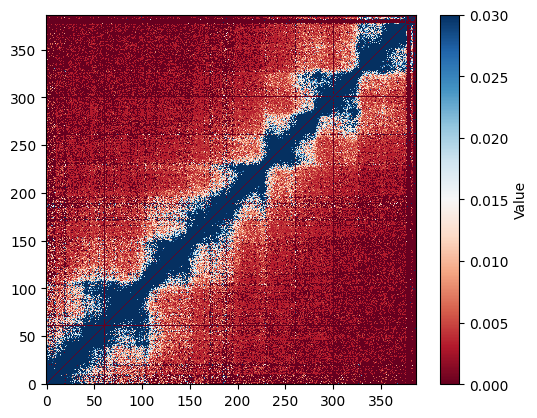

In [94]:
# original matrix(fq)
original = get_hic_data_matrix(conn, chromosome_name, cell_line, sequences)
plt.imshow(original, cmap='RdBu', interpolation='nearest', origin='lower', vmin=0, vmax=0.03)
plt.colorbar(label="Value")
plt.show()

In [ ]:
avg_distance_data = get_avg_distance_data(conn, chromosome_name, cell_line, sequences)
plt.imshow(avg_distance_data, cmap='Reds_r', interpolation='nearest', origin='lower')
plt.colorbar(label="Value")
plt.show()

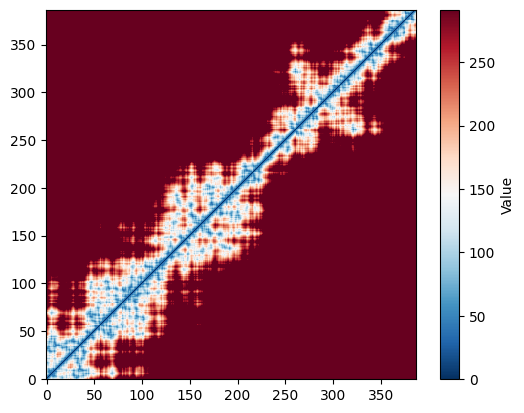

In [95]:
# Spearman correlation
min_val = np.min(sample_distance_vector)
max_val = np.max(sample_distance_vector)
plt.imshow(sample_distance_vector, cmap='RdBu_r', interpolation='nearest', origin='lower', vmin=min_val, vmax=0.17*max_val)
plt.colorbar(label="Value")
plt.show()

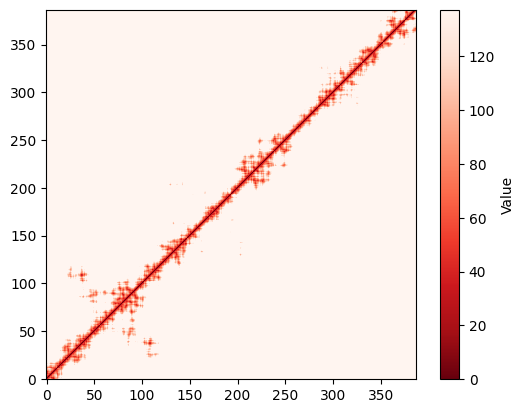

In [49]:
# distance correlation
min_val = np.min(sample_distance_vector)
max_val = np.max(sample_distance_vector)
plt.imshow(sample_distance_vector, cmap='Reds_r', interpolation='nearest', origin='lower', vmin=min_val, vmax=0.12*max_val)
plt.colorbar(label="Value")
plt.show()